This notebook shows how you can extract the data (images, pointcloud) and meta-data (calibration information, annotations) from a hdf5 file with h5py.

In [27]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from scipy.spatial.transform import Rotation as R
import open3d as o3d

Set path to one file of the Lake Constance Obstacle Detection Train- or Test-set

In [28]:
FILE_PATH = "/media/dennis/Extreme SSD1/converted_object_detection_dataset_imu/train/1659018892_500.hdf5"

Read the data

In [29]:
with h5py.File(FILE_PATH, "r") as f:
    pc = f["pointcloud"][:]
    left_img = f["left_image/image"][:]
    K_l = f["left_image/K"][:]
    D_l = f["left_image/D"][:]
    R_l = f["left_image/R"][:]
    P_l = f["left_image/P"][:]
        
    right_img = f["right_image/image"][:]
    K_r = f["right_image/K"][:]
    D_r = f["right_image/D"][:]
    R_r = f["right_image/R"][:]
    P_r = f["right_image/P"][:]

    R_cam_lidar = f["calib_lidar_to_cam/R"][:]
    t_cam_lidar = f["calib_lidar_to_cam/t"][:]

    R_caml_camr = f["calib_cam_r_to_cam_l/R"][:]
    t_caml_camr = f["calib_cam_r_to_cam_l/t"][:]

    R_plane_cam = f["calib_cam_to_plane/R"][:]
    t_plane_cam = f["calib_cam_to_plane/t"][:]

    imu_orientation = f["imu_orientation"][:]


    bbox_label_int = []
    bbox_label_str = []
    bbox_location = []
    bbox_dimensions = []
    bbox_rotation_y = []
    bbox_visibility = []
    bbox_occlusion = []

    i = 0
    while True:
        try:
            bbox_label_int.append(f["bounding_boxes/bounding_box_" + str(i) + "/category/int"][()])
            bbox_label_str.append(f["bounding_boxes/bounding_box_" + str(i) + "/category/name"][()].decode("utf-8"))
            bbox_location.append(f["bounding_boxes/bounding_box_" + str(i) + "/location"][:])
            bbox_dimensions.append(f["bounding_boxes/bounding_box_" + str(i) + "/dimensions"][:])
            bbox_rotation_y.append(f["bounding_boxes/bounding_box_" + str(i) + "/rotation_y"][()])
            bbox_visibility.append(f["bounding_boxes/bounding_box_" + str(i) + "/visibility"][()])
            bbox_occlusion.append(f["bounding_boxes/bounding_box_" + str(i) + "/occlusion"][()])
            i += 1
        except:
            break

Convert images to dtype float64

In [30]:
left_img_float = left_img / np.iinfo("uint16").max
right_img_float = right_img / np.iinfo("uint16").max

Compute the rectified images of the stereo system

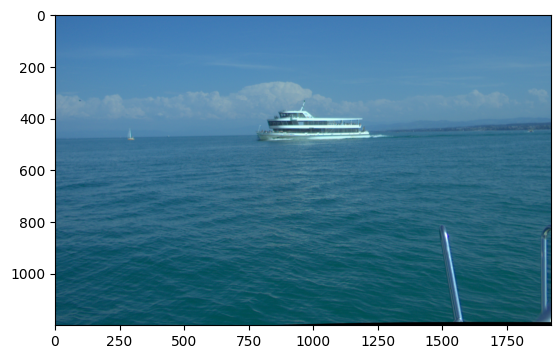

In [31]:
map1_left, map2_left = cv2.initUndistortRectifyMap(K_l, D_l, R_l, P_l, (left_img.shape[1], left_img.shape[0]), cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(K_r, D_r, R_r, P_r, (right_img.shape[1], right_img.shape[0]), cv2.CV_32FC1)

left_img_rect = cv2.remap(left_img_float, map1_left, map2_left, cv2.INTER_LINEAR)
right_img_rect = cv2.remap(right_img_float, map1_right, map2_right, cv2.INTER_LINEAR)
plt.imshow(left_img_rect)

Helper functions

In [32]:
def create_T_matrix(R, t):
    """
    Create a 4x4 transformation matrix from a rotation matrix and a translation vector
    param R: 3x3 rotation matrix
    param t: 3x1 translation vector
    return: 4x4 transformation matrix
    """
    T = np.zeros((4,4))
    T[3,3] = 1
    T[:3,:3] = R
    T[:3, 3] = t
    return T

In [33]:
def dot_size(coords, img_shape, size=3):
    """
    Create a range of coordinates around a given set of coordinates
    param coords: Nx2 array of coordinates
    param img_shape: tuple of image shape
    param size: size of the range
    return: Kx2 array of coordinates
    """
    half_size = size // 2
    mask = np.all([coords[:,0]-half_size > 0, coords[:,1]-half_size > 0, coords[:,1]+half_size < img_shape[0], coords[:,0]+half_size < img_shape[1]],axis=0)
    range_coords = coords[mask]

    a = np.linspace(-half_size, half_size, size)
    b = np.linspace(-half_size, half_size, size)
    x, y = np.meshgrid(a, b)
    kernel = np.array([x.flatten(), y.flatten()]).T

    range_coords = range_coords.reshape(range_coords.shape[0], 1, 2)
    range_coords = np.repeat(range_coords, [size*size], axis=0).reshape(range_coords.shape[0], size*size, 2) + kernel
    return range_coords.reshape(range_coords.shape[0] * range_coords.shape[1], 2).astype('int')

Transform lidar points into rectified left stereo camera image

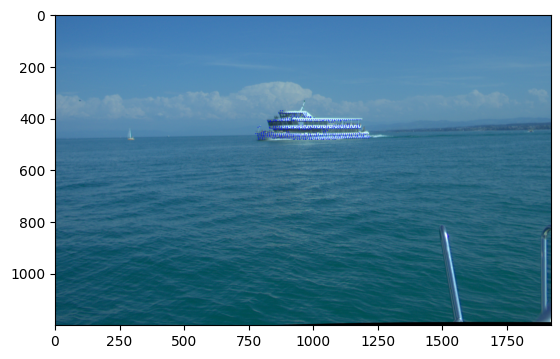

In [34]:
pc_hom = np.zeros((pc.shape[0], 4))
pc_hom[:,3] = 1
pc_hom[:,:3] = pc[:,:3]
# use only points in front of the sensor
mask = pc_hom[:,0] > 4
pc_hom = pc_hom[mask]

T_cam_lidar = create_T_matrix(R_cam_lidar, t_cam_lidar)

# transform point cloud to image coordinates
img_coords_hom = (P_l @ T_cam_lidar @ np.expand_dims(pc_hom, axis=2)).squeeze(2)
img_coords = np.true_divide(img_coords_hom[:,:2], img_coords_hom[:,[-1]])

# plot only points in camera frustum
height = left_img_rect.shape[0]
width = left_img_rect.shape[1]

img_coords = img_coords.astype(np.uint16)
mask1 = np.all([img_coords[:,0] >= 0, img_coords[:,0] < width] , axis = 0)
mask2 = np.all([img_coords[:,1] >= 0 ,img_coords[:,1] < height] , axis = 0)
mask = np.all([mask1, mask2], axis=0)
img_coords = img_coords[mask]

img_coords = dot_size(img_coords, left_img_rect.shape, size=3)
img_coords = np.transpose(img_coords, (1,0))

left_img_rect_points = copy.deepcopy(left_img_rect)
left_img_rect_points[img_coords[1], img_coords[0]] = [0,0,1]
plt.imshow(left_img_rect_points)

Define 3d bounding boxes in water plane coordinate system

In [35]:
bboxes_list = []
for i in range(len(bbox_label_int)):
    w, h, l = bbox_dimensions[i][0], bbox_dimensions[i][1], bbox_dimensions[i][2]
    location = bbox_location[i]
    rotation_y = bbox_rotation_y[i]
    bbox_points = np.array([[-w/2, h/2, l/2], [w/2, h/2, l/2], [w/2, h/2, -l/2], [-w/2, h/2, -l/2],
                            [-w/2, -h/2, l/2], [w/2, -h/2, l/2], [w/2, -h/2, -l/2], [-w/2, -h/2, -l/2]])
    rotation_matrix = R.from_euler("y", rotation_y, degrees=False).as_matrix()
    bbox_points = (rotation_matrix @ np.expand_dims(bbox_points, axis=2)).squeeze(2)
    bbox_points += location
    bboxes_list.append(bbox_points)

Transform the 3d coordinates of the bounding box into rectified left camera image

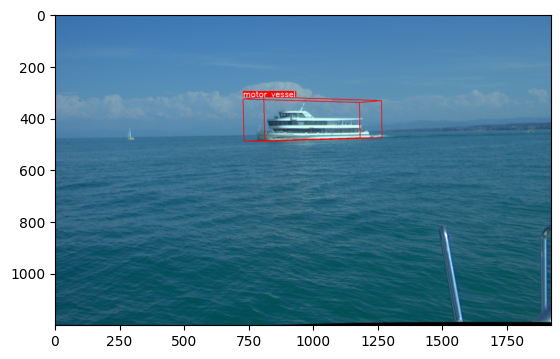

In [36]:
T_plane_cam = create_T_matrix(R_plane_cam, t_plane_cam)
T_cam_plane = np.linalg.inv(T_plane_cam)

for i, bbox in enumerate(bboxes_list):
    # transform from plane to camera and into image
    ones = np.ones((bbox.shape[0], 1))
    bbox_hom = np.concatenate((bbox, ones), axis=1)
    img_coords_corners_hom = (P_l @ T_cam_plane @ np.expand_dims(bbox_hom, axis=2)).squeeze(2)
    img_coords_corners = np.true_divide(img_coords_corners_hom[:,:2], img_coords_corners_hom[:,[-1]])

    p1_i = np.array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3])
    p2_i = np.array([1, 2, 3, 0, 5, 6, 7, 4, 4, 5, 6, 7])

    for line_seg in zip(p1_i, p2_i):
        p1 = img_coords_corners[line_seg[0]].astype("uint16")
        p2 = img_coords_corners[line_seg[1]].astype("uint16")
        
        local_left_img_rect = cv2.line(left_img_rect, tuple(p1), tuple(p2), color=(1,0,0), thickness=2)

    # write class label at highest point
    y_min = img_coords_corners[:,1].min()
    x_min = img_coords_corners[:,0].min()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (int(x_min), int(y_min))
  
    # fontScale
    fontScale = 1    
    # Blue color in BGR
    color = (1, 1, 1)
    # Line thickness of 1 px
    thickness = 2

    text_size, _ = cv2.getTextSize(bbox_label_str[i], font, fontScale, thickness)
    text_w, text_h = text_size
    x, y = pos[0], pos[1]
    cv2.rectangle(local_left_img_rect, pos, (x + text_w, y - text_h), (1,0,0), -1)

    local_left_img_rect = cv2.putText(local_left_img_rect, bbox_label_str[i], pos, font,
                   fontScale, color, thickness, cv2.LINE_AA)
    
plt.imshow(local_left_img_rect)

Transform lidar point cloud to water plane coordinate system and visualize bounding boxes and the pointcloud with open3d

In [37]:
pc_hom = np.zeros((pc.shape[0], 4))
pc_hom[:,3] = 1
pc_hom[:,:3] = pc[:,:3]
# use only points in front of the sensor
mask = pc_hom[:,0] > 4
pc_hom = pc_hom[mask]

# transform from lidar to camera and from camera to plane
plane_coords_corners_hom = (T_plane_cam @ T_cam_lidar @ np.expand_dims(pc_hom, axis=2)).squeeze(2)
plane_coords_corners = np.true_divide(plane_coords_corners_hom[:,:3], plane_coords_corners_hom[:,[-1]])
o3d_pc = o3d.geometry.PointCloud()
o3d_pc.points = o3d.utility.Vector3dVector(plane_coords_corners)

In [38]:
o3d_elements = []

for i, bbox in enumerate(bboxes_list):
    o3d_bbox = o3d.geometry.OrientedBoundingBox()
    o3d_bbox = o3d_bbox.create_from_points(o3d.utility.Vector3dVector(bbox_points))
    o3d_bbox.color = [1,0,0]
    o3d_elements.append(o3d_bbox)

# add point cloud to elements
o3d_elements.append(o3d_pc)

o3d.visualization.draw_geometries(o3d_elements)